# Challenge 3: Artifical Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [KMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
    * Provide a grid plot of the first 10/12 examples with associated labels
    * Split using the provided pytorch objects into train/validation/test sets
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion. Discuss the choice you made in the report.
3. Summarise your results in a table and comment on them in the report. 
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.
    * Beyond accuracy provide the confusion matrix for the model outputs. Discuss differences between train/validation/test sets. Is accuracy a good metric in this case why or why not?

In [93]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision

In [83]:
from torchvision.datasets import KMNIST
from torchvision import transforms

transform = transforms.ToTensor()
train_set = KMNIST(root='./data', train=True, download=True, transform=transform)
test_set = KMNIST(root='./data', train=False, download=True, transform=transform)


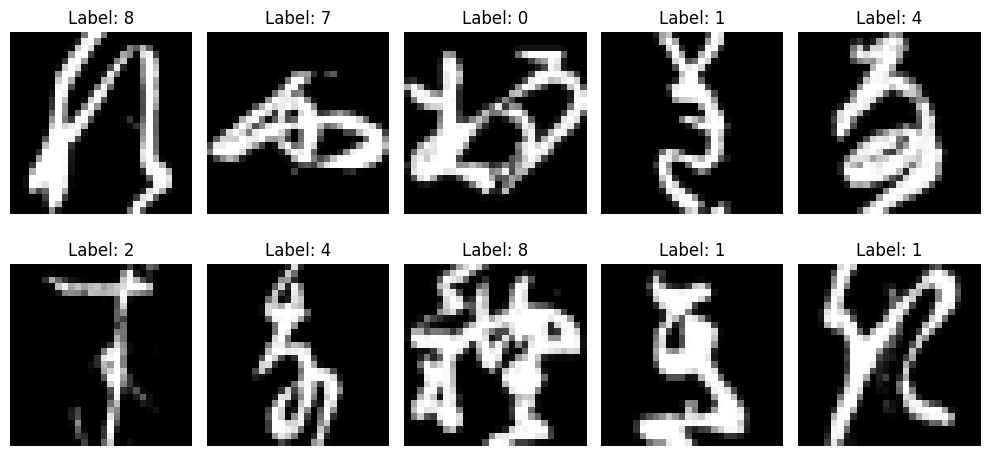

In [84]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 rows, 5 columns
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(train_set.data[i], cmap='gray')
    ax.set_title(f"Label: {train_set.targets[i]}")
    ax.axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()


In [95]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

In [96]:
def evaluate(model, val_loader, device):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader, 0):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_acc += get_batch_accuracy(outputs, labels)
    return test_acc / i


In [97]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [91]:
import torch.nn as nn

class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.model(x)


In [92]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

In [88]:
batch_train_subset = DataLoader(train_subset, batch_size=64, shuffle=True)
batch_val_subset = DataLoader(val_subset, batch_size=64, shuffle=True)

In [59]:
results = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [60]:
def log_result_epoch(model_type, hidden_layers, optimizer_name, lr, batch_size,
                     dropout, weight_decay, train_loss, val_loss,
                     train_acc, val_acc, epoch, notes=""):
    results.append({
        'Epoch': epoch,
        'Model Type': model_type,
        'Hidden Layers': hidden_layers,
        'Optimizer': optimizer_name,
        'Learning Rate': lr,
        'Batch Size': batch_size,
        'Dropout': dropout,
        'Weight Decay': weight_decay,
        'Train Loss': round(train_loss, 4),
        'Val Loss': round(val_loss, 4),
        'Train Accuracy (%)': round(train_acc * 100, 2),
        'Val Accuracy (%)': round(val_acc * 100, 2),
        'Notes': notes
    })


In [62]:
def train_and_log_each_epoch(model, model_type, hidden_layers, optimizer, optimizer_name,
                              lr, batch_size, dropout, weight_decay,
                              train_loader, val_loader, device, notes=""):

    model.to(device)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(10):
        model.train()
        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation evaluation
        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct_val / total_val

        # Log everything
        log_result_epoch(model_type, hidden_layers, optimizer_name, lr, batch_size,
                         dropout, weight_decay, avg_train_loss, avg_val_loss,
                         train_acc, val_acc, epoch + 1, notes)


In [70]:
# Define your base model architecture
def create_model():
    return CNN()  # Or CNN()

# Define optimizer configs to test
optimizer_configs = [
    ('Adam', lambda params: torch.optim.Adam(params, lr=0.001, weight_decay=1e-5)),
    ('SGD', lambda params: torch.optim.SGD(params, lr=0.01, momentum=0.9)),
    ('RMSprop', lambda params: torch.optim.RMSprop(params, lr=0.001, weight_decay=1e-5))
]

# Loop over each optimizer
for opt_name, opt_fn in optimizer_configs:
    model = create_model()
    optimizer = opt_fn(model.parameters())

    train_and_log_each_epoch(
        model=model,
        model_type='FCNN',
        hidden_layers='256 → 128',
        optimizer=optimizer,
        optimizer_name=opt_name,
        lr=optimizer.param_groups[0]['lr'],
        batch_size=64,
        dropout=0.2,
        weight_decay=optimizer.param_groups[0].get('weight_decay', 0),
        train_loader=batch_train_subset,
        val_loader=batch_val_subset,
        device=device,
        notes='Optimizer test run'
    )


In [71]:
df_CNN = pd.DataFrame(results)
df_CNN.sort_values(by='Val Accuracy (%)', ascending=False)

,Epoch,Model Type,Hidden Layers,Optimizer,Learning Rate,Batch Size,Dropout,Weight Decay,Train Loss,Val Loss,Train Accuracy (%),Val Accuracy (%),Notes
58,9,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0224,0.0607,99.22,98.52,Optimizer test run
39,10,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.0160,0.0631,99.48,98.47,Optimizer test run
59,10,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0200,0.0654,99.37,98.45,Optimizer test run
56,7,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0298,0.0622,99.07,98.42,Optimizer test run
57,8,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0255,0.0629,99.18,98.37,Optimizer test run
49,10,FCNN,256 → 128,SGD,0.010,64,0.2,0.00000,0.0199,0.0659,99.33,98.31,Optimizer test run
38,9,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.0175,0.0685,99.39,98.31,Optimizer test run
54,5,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0467,0.0609,98.48,98.30,Optimizer test run
35,6,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.0260,0.0615,99.13,98.28,Optimizer test run
47,8,FCNN,256 → 128,SGD,0.010,64,0.2,0.00000,0.0290,0.0629,99.04,98.26,Optimizer test run


In [66]:
df_FCNN = pd.DataFrame(results)
df_FCNN.sort_values(by='Val Accuracy (%)', ascending=False)

,Epoch,Model Type,Hidden Layers,Optimizer,Learning Rate,Batch Size,Dropout,Weight Decay,Train Loss,Val Loss,Train Accuracy (%),Val Accuracy (%),Notes
28,9,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0660,0.1487,97.88,96.14,Optimizer test run
8,9,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.0691,0.1582,97.77,96.11,Optimizer test run
26,7,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0813,0.1504,97.38,96.01,Optimizer test run
7,8,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.0726,0.1536,97.70,95.97,Optimizer test run
27,8,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0737,0.1594,97.66,95.92,Optimizer test run
29,10,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.0591,0.1687,98.05,95.92,Optimizer test run
24,5,FCNN,256 → 128,RMSprop,0.001,64,0.2,0.00001,0.1076,0.1550,96.61,95.73,Optimizer test run
18,9,FCNN,256 → 128,SGD,0.010,64,0.2,0.00000,0.0772,0.1594,97.51,95.73,Optimizer test run
6,7,FCNN,256 → 128,Adam,0.001,64,0.2,0.00001,0.0843,0.1604,97.22,95.66,Optimizer test run
16,7,FCNN,256 → 128,SGD,0.010,64,0.2,0.00000,0.1029,0.1558,96.71,95.62,Optimizer test run


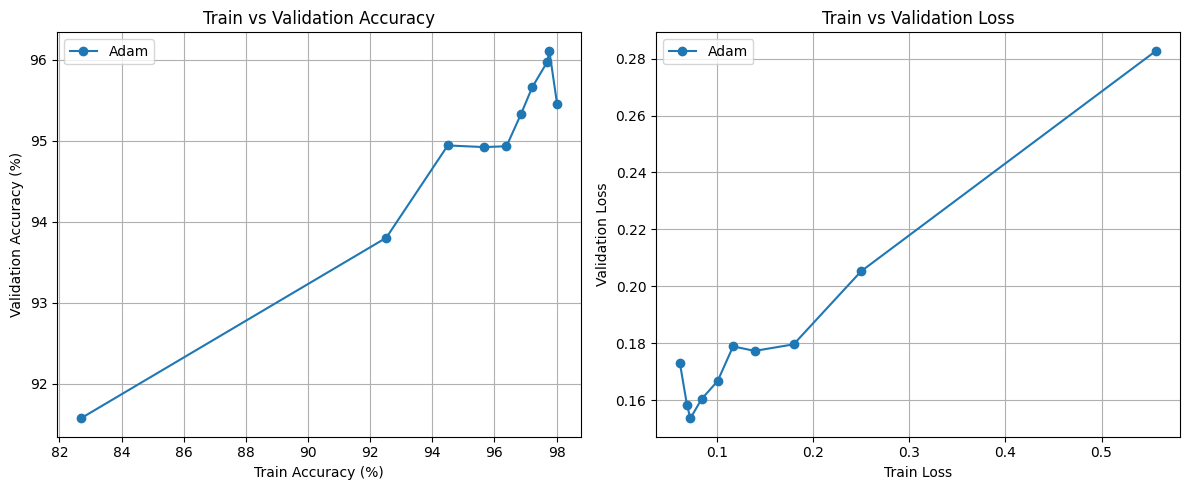

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax[0].plot(df_FCNN[df_FCNN['Optimizer'] == 'Adam']['Train Accuracy (%)'], df_FCNN[df_FCNN['Optimizer'] == 'Adam']['Val Accuracy (%)'],
               marker='o', label='Adam')
ax[0].set_xlabel('Train Accuracy (%)')
ax[0].set_ylabel('Validation Accuracy (%)')
ax[0].set_title('Train vs Validation Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss plot
ax[1].plot(df_FCNN[df_FCNN['Optimizer'] == 'Adam']['Train Loss'], df_FCNN[df_FCNN['Optimizer'] == 'Adam']['Val Loss'],
               marker='o', label='Adam')
ax[1].set_xlabel('Train Loss')
ax[1].set_ylabel('Validation Loss')
ax[1].set_title('Train vs Validation Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

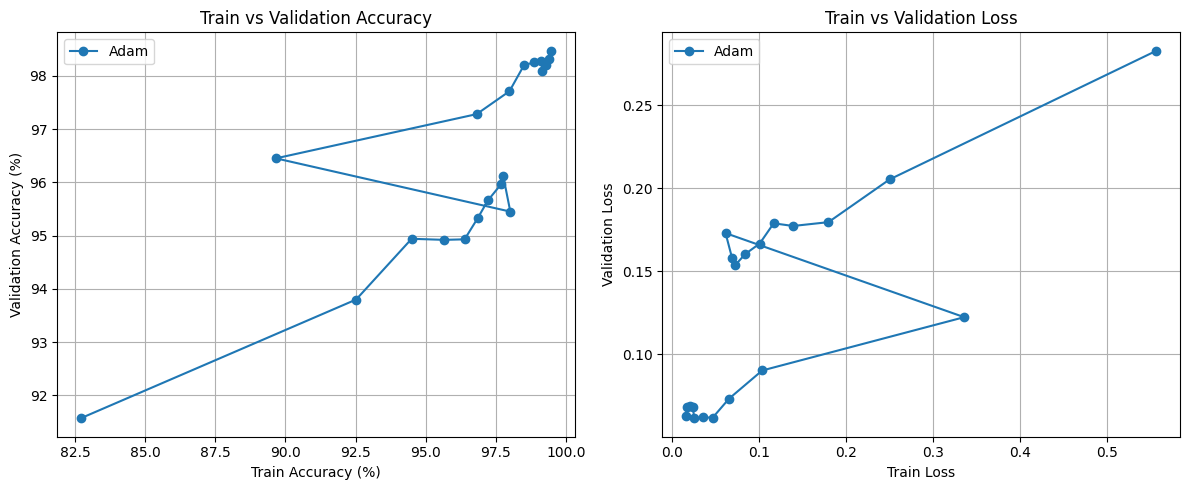

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
ax[0].plot(df_CNN[df_CNN['Optimizer'] == 'Adam']['Train Accuracy (%)'], df_CNN[df_CNN['Optimizer'] == 'Adam']['Val Accuracy (%)'],
               marker='o', label='Adam')
ax[0].set_xlabel('Train Accuracy (%)')
ax[0].set_ylabel('Validation Accuracy (%)')
ax[0].set_title('Train vs Validation Accuracy')
ax[0].legend()
ax[0].grid(True)

# Loss plot
ax[1].plot(df_CNN[df_CNN['Optimizer'] == 'Adam']['Train Loss'], df_CNN[df_CNN['Optimizer'] == 'Adam']['Val Loss'],
               marker='o', label='Adam')
ax[1].set_xlabel('Train Loss')
ax[1].set_ylabel('Validation Loss')
ax[1].set_title('Train vs Validation Loss')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

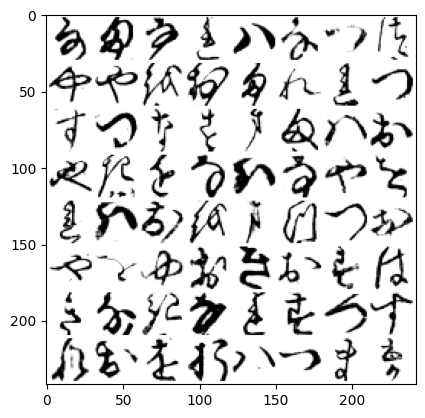

In [105]:
from torch.utils.tensorboard import SummaryWriter

num_epochs = 10
model = CNN().to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize tensorboard writer
writer = SummaryWriter()

# get images from dataloader
dataiter = iter(batch_train_subset)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)


In [ ]:
# write to tensorboard
writer.add_image('Kmnist_images_FCNN', img_grid)

for epoch in range(num_epochs):
    model.train()
    train_loss=0.0
    train_acc = 0.0
    for i, (images, labels) in enumerate(batch_train_subset):    
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += get_batch_accuracy(logits, labels)
    writer.add_scalar('Loss/train', train_loss/i, epoch)
    writer.add_scalar('Accuracy/train', train_acc/i, epoch)
    model.eval()  # Set the model to evaluation mode

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/i:.4f}, Train Acc {train_acc/i:.4f}')

# Close the TensorBoard writer
writer.flush() # write to disk
writer.close() 

Epoch [1/10], Train Loss: 0.3884, Train Acc 88.3261
Epoch [2/10], Train Loss: 0.1191, Train Acc 96.5517
Epoch [3/10], Train Loss: 0.0791, Train Acc 97.7512
Epoch [4/10], Train Loss: 0.0582, Train Acc 98.3395
Epoch [5/10], Train Loss: 0.0438, Train Acc 98.7504
Epoch [6/10], Train Loss: 0.0357, Train Acc 98.8902
Epoch [7/10], Train Loss: 0.0265, Train Acc 99.2532
Epoch [8/10], Train Loss: 0.0237, Train Acc 99.3470
Epoch [9/10], Train Loss: 0.0201, Train Acc 99.5056


In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(batch_val_subset, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)
        
print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 98.8386


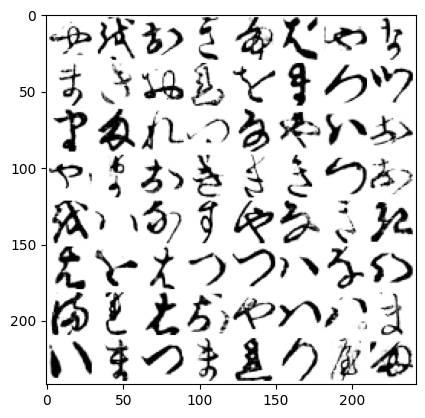

In [101]:
num_epochs = 10
model = FCNN().to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize tensorboard writer
writer = SummaryWriter()

# get images from dataloader
dataiter = iter(batch_train_subset)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=True)

In [103]:
# write to tensorboard
writer.add_image('Kmnist_images_FCNN', img_grid)

for epoch in range(num_epochs):
    model.train()
    train_loss=0.0
    train_acc = 0.0
    for i, (images, labels) in enumerate(batch_train_subset):    
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += get_batch_accuracy(logits, labels)
    writer.add_scalar('Loss/train', train_loss/i, epoch)
    writer.add_scalar('Accuracy/train', train_acc/i, epoch)
    model.eval()  # Set the model to evaluation mode

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/i:.4f}, Train Acc {train_acc/i:.4f}')

# Close the TensorBoard writer
writer.flush() # write to disk
writer.close() 

Epoch [1/10], Train Loss: 0.5478, Train Acc 83.3632
Epoch [2/10], Train Loss: 0.2445, Train Acc 92.7654
Epoch [3/10], Train Loss: 0.1793, Train Acc 94.6095
Epoch [4/10], Train Loss: 0.1392, Train Acc 95.9279
Epoch [5/10], Train Loss: 0.1170, Train Acc 96.4432
Epoch [6/10], Train Loss: 0.0968, Train Acc 97.0440
Epoch [7/10], Train Loss: 0.0855, Train Acc 97.4675
Epoch [8/10], Train Loss: 0.0745, Train Acc 97.7449
Epoch [9/10], Train Loss: 0.0666, Train Acc 97.9055
Epoch [10/10], Train Loss: 0.0602, Train Acc 98.1538


In [104]:
test_acc = 0.0
for i, (images, labels) in enumerate(batch_val_subset, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)
        
print(f"Test Accuracy: {test_acc/i:.4f}")

Test Accuracy: 96.5157
